In [1]:
import cloudscraper
import re
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(8281)


# Exploring NFL odds
I'm looking at NFL odds, particularly the question of how the betting public does betting on the NFL. The question, that I've previously asked about the NBA, is do they do better or worse than a coin flip?


## getting the data
I'm trying to get NFL odds from yahoo, which I previously used to get NBA odds... of course the UX of the page and the backend calls for data are totally different than NBA, because yahoo

these urls contain the line, but not the betting percentages.
https://graphite.sports.yahoo.com/v1/query/shangrila/moduleGame?lang=en-US&region=US&ysp_platform=next-app-sports&gameId=nfl.g.20251225028

for comparison, the NBA one with all the gold is:

    return f"https://sports.yahoo.com/site/api/resource/sports.graphite.gameOdds;dataType=graphite;endpoint=graphite;gameIds={game_id}"

I wonder if this works...

https://sports.yahoo.com/site/api/resource/sports.graphite.gameOdds;dataType=graphite;endpoint=graphite;gameIds=nfl.g.20251225028


Wait, holy cow, it does (see below)! I can use that endpoint as an `undocumented API` for NFL betting data


here is a sample NFL game ID: `nfl.g.20251225028`

so like the NBA code, it will go through each calendar page, scrape the game IDs out of the HTML, then query the above endpoint for the details and parse it into JSON

In [2]:
#import scrape_yahoo
# SAMPLE_NFL_GAME = "nfl.g.20251225028"

# url = scrape_yahoo.make_yahoo_json_url(SAMPLE_NFL_GAME)
# json_data = scrape_yahoo.get_some_json(url)
# parsed = scrape_yahoo.parse_yahoo_data(json_data)

the parsing from NBA works flawlessly (as far as I can tell)

In [3]:
# parsed

### week by week calendar function to get game ids
here is week 2 of the current season:

https://sports.yahoo.com/nfl/scoreboard/?confId=&dateRange=2&schedState=2

here is week 2 of the 2022 season:

https://sports.yahoo.com/nfl/scoreboard/?confId=&dateRange=2&schedState=2&scoreboardSeason=2022

`dateRange` is the week of the season. I don't know what `schedState` is for

this gets 25 game ids...

the scrape_yahoo logic will ignore a game if we've already fetched it. just gotta make sure that it's only doing the current year (eg 2022 games only)

I should probably refactor the code to be a class, etc. but this is easier.

I'm just overriding some functions from the NBA code here.

fetch_yahoo_data occasionally hits errors. there are a few games missing

I manually ran this for all 5 seasons.

had to re-run it to pick up some missing games.

In [4]:
from scrape_yahoo_nfl import *
scraper = ScrapeYahooNFL()

In [5]:
FETCH = False # stop trying to make fetch happen

if FETCH:
    for yyyy in range(2021, 2026):
        print(f">>>>> ON YEAR {yyyy}")
        scraper.fetch_yahoo_data(dir=f"nfl_scrapes/{yyyy}", year=yyyy)

there is an error parsing this one game:
`file: nfl_scrapes/2022\nfl.g.20220918018.json failed on $.data.games.[0].gameLineSixPack.[?[Expression(Fields('type') = 'under_UNDER'), Expression(Fields('period') = 'FULL_GAME'), Expression(Fields('eventState') = 'PREGAME')]].options.[0].optionDetails.[0].value`

it doesn't have the `FULL_GAME` odds, only the live odds

## gotta catch em all

there are 1360 games total across the 5 nfl seasons

In [6]:

all_filenames = scraper.get_cached_filenames("nfl_scrapes/*")


In [7]:
len(all_filenames)

1360

get all of them in one big df.. this takes 10ish seconds

In [8]:
df_all = scraper.get_all_data()

file: nfl_scrapes/2022\nfl.g.20220918018.json failed on $.data.games.[0].gameLineSixPack.[?[Expression(Fields('type') = 'OVER_UNDER'), Expression(Fields('period') = 'FULL_GAME'), Expression(Fields('eventState') = 'PREGAME')]].options.[0].optionDetails.[0].value
file: nfl_scrapes/2022\nfl.g.20220918018.json failed on $.data.games.[0].gameLineSixPack.[?[Expression(Fields('type') = 'OVER_UNDER'), Expression(Fields('period') = 'FULL_GAME'), Expression(Fields('eventState') = 'PREGAME')]].options.[0].stakePercentage
file: nfl_scrapes/2022\nfl.g.20220918018.json failed on $.data.games.[0].gameLineSixPack.[?[Expression(Fields('type') = 'OVER_UNDER'), Expression(Fields('period') = 'FULL_GAME'), Expression(Fields('eventState') = 'PREGAME')]].options.[0].wagerPercentage
file: nfl_scrapes/2022\nfl.g.20220918018.json failed on $.data.games.[0].gameLineSixPack.[?[Expression(Fields('type') = 'OVER_UNDER'), Expression(Fields('period') = 'FULL_GAME'), Expression(Fields('eventState') = 'PREGAME')]].opti

In [9]:
df_all.season.value_counts()

season
2021    272
2022    272
2023    272
2024    272
2025    272
Name: count, dtype: int64

In [10]:
len(df_all)

1360

this data includes one game that was postponed, so we need to delete it. I found this while cross-linking with data from pro-football-reference later on in the notebook.

In [11]:
df_all = df_all[df_all.game_id != "nfl.g.20230102004"].copy()

In [12]:
len(df_all)

1359

In [13]:
df_all.head(5)

,game_id,game_date,away_team,home_team,pregame_odds,total_over_points,total_over_stake_percentage,total_over_wager_percentage,total_over_odds,total_over_decimal_odds,...,spread_away_stake_percentage,spread_away_wager_percentage,spread_away_won,spread_home_points,spread_home_odds,spread_home_decimal_odds,spread_home_stake_percentage,spread_home_wager_percentage,spread_home_won,season
0,nfl.g.20210909027,2021-09-09-07:00,Dallas,Tampa Bay,"-9, O/U 52.5",52.5,45.48,54.45,-110.0,1.910,...,24.31,25.98,True,-9,-110.0,1.910,75.69,74.02,False,2021
0,nfl.g.20210912001,2021-09-12-07:00,Philadelphia,Atlanta,"-3.5, O/U 48.5",48.5,94.77,91.39,-110.0,1.910,...,45.16,41.19,True,-3.5,-110.0,1.910,54.84,58.81,False,2021
0,nfl.g.20210912002,2021-09-12-07:00,Pittsburgh,Buffalo,"-6.5, O/U 48",48,87.16,90.98,-110.0,1.910,...,30.38,43.7,True,-6.5,-110.0,1.910,69.62,56.3,False,2021
0,nfl.g.20210912004,2021-09-12-07:00,Minnesota,Cincinnati,"-3, O/U 47",47,None,None,-110.0,1.910,...,79.35,66.23,False,3,-115.0,1.870,20.65,33.77,True,2021
0,nfl.g.20210912008,2021-09-12-07:00,San Francisco,Detroit,"-7.5, O/U 45.5",45.5,83.16,92.43,-110.0,1.910,...,87.48,82.41,True,7.5,-115.0,1.870,12.52,17.59,False,2021


In [14]:
17 * 16 # 17 games a season, 32 teams (so 16 games)

272

we're not missing any games (except the one I had to delete above)

In [15]:
df_all.groupby('season').count()

,game_id,game_date,away_team,home_team,pregame_odds,total_over_points,total_over_stake_percentage,total_over_wager_percentage,total_over_odds,total_over_decimal_odds,...,spread_away_decimal_odds,spread_away_stake_percentage,spread_away_wager_percentage,spread_away_won,spread_home_points,spread_home_odds,spread_home_decimal_odds,spread_home_stake_percentage,spread_home_wager_percentage,spread_home_won
season,,,,,,,,,,,,,,,,,,,,,
2021,272,272,272,272,272,272,205,205,272,272,...,272,206,206,270,272,272,272,205,205,270
2022,271,271,271,271,271,270,254,254,270,270,...,270,255,255,264,270,270,270,255,255,264
2023,272,272,272,272,272,272,214,214,272,272,...,272,214,214,261,272,272,272,214,214,261
2024,272,272,272,272,272,272,272,272,272,272,...,272,272,272,268,272,272,272,272,272,268
2025,272,272,272,272,272,272,272,272,272,272,...,272,272,272,270,272,272,272,272,272,270


In [16]:
import spread_data

df_all = spread_data.add_spread_columns(df_all)

In [17]:
df_all.spread_popular_won.isna().any()

np.False_

In [18]:
df_all.spread_popular_won.value_counts()

spread_popular_won
False    755
True     604
Name: count, dtype: int64

overall, the less popular side (by wager percentage) wins 55.4% of the time!

In [19]:
## this is copy/pasted from another project

from scipy.stats import norm

def win_loss_report(wins, losses, vig=1.1):
    win_pct = wins / (wins+losses)
    expected_wins = (wins + losses) /2
    std = np.sqrt(wins + losses)/2 # sqrt(n*p*(1-p)) = sqrt(n * .5 * .5) = sqrt(n)/2
    z_score = (wins-expected_wins) / std
    p_value = norm.cdf(z_score)
    profit_pct = 100 * (win_pct - (vig * (1-win_pct))) / 1.1

    # betting markets are more like visa/mastercard. the side getting paid covers 
    # the cost for facilitating the transaction.

    # there isn't necessarily vig on the bet itself, because you are betting
    # against another person, not the house.

    # however, people who provide liquidity for the betting market want to make money 
    # for their troubles, so there is usually a little bit of vig.
     
    # On matchbook.com, this appears to be around .3%-.7% for NBA basketball. 
    # eg. [+102/-105.26] for spread or [-208/+205] for money line

    # On ProphetX (newish market, low volume), it is around .2% on big events
    # eg [-112/+111] on the superbowl ML right now
    # but closer to 1.2-1.7% on NBA: [-107/+102] --1.1%, [-103/-102] --1.2%, [100/-105] --1.2% 
    # [-101, -106] -- 1.7%

    # On novig (new market, almost no volume), they are like [-105/-104] - 2.2%, [+109/-127] - 3.7% 
    # [-108/-105] - 3%

    # I am estimating it at 1.7%.

    betting_market = (.97*wins) - (1.017 * losses)

    print(f"record:   {wins} - {losses}")
    if vig != 1.1:
        print(f"actual ({vig} vig) units: { round(wins - (vig*losses), 2)}")
    
    print(f"full vig (-110) units: { round(wins - (1.1*losses),2) }")
    print(f"reduced juice (-106) : { round(wins - (1.06 * losses),2) }")
    print(f"reduced juice (-105) : { round(wins - (1.05 * losses),2) }")
    print(f"betting market       : { round(betting_market, 2) }")

    print(f"win pct: {round(100 *win_pct,2)}%, expected wins: {expected_wins}")
    print(f"excess: {wins - expected_wins}, profit %: {round(profit_pct,2)}")
    print(f"z test: {round(z_score,2)}, std: {round(std,2)} , p-value: {round(1-p_value, 4)}")



In [20]:
win_loss_report(755,604)

record:   755 - 604
full vig (-110) units: 90.6
reduced juice (-106) : 114.76
reduced juice (-105) : 120.8
betting market       : 118.08
win pct: 55.56%, expected wins: 679.5
excess: 75.5, profit %: 6.06
z test: 4.1, std: 18.43 , p-value: 0.0


In [21]:
season_grouper = df_all.groupby("season")

In [22]:
season_grouper["spread_popular_won"].value_counts()

season  spread_popular_won
2021    False                 164
        True                  108
2022    False                 152
        True                  119
2023    False                 167
        True                  105
2024    True                  143
        False                 129
2025    False                 143
        True                  129
Name: count, dtype: int64

In [23]:
result_percents = season_grouper["spread_popular_won"].value_counts() / season_grouper.count()['spread_popular_won']

In [24]:
result_percents

season  spread_popular_won
2021    False                 0.602941
        True                  0.397059
2022    False                 0.560886
        True                  0.439114
2023    False                 0.613971
        True                  0.386029
2024    True                  0.525735
        False                 0.474265
2025    False                 0.525735
        True                  0.474265
dtype: float64

here are winning percentages by year for the less popular team (by wager percentage)

that's been a winning proposition in 4/5 years. kind of impressive.

In [25]:
fade_win_pct = result_percents[:, False] # False means the popular side didn't win

fade_win_pct

season
2021    0.602941
2022    0.560886
2023    0.613971
2024    0.474265
2025    0.525735
dtype: float64

In [26]:
fade_win_pct.values

array([0.60294118, 0.56088561, 0.61397059, 0.47426471, 0.52573529])

confidence interval for each season

In [27]:
from statsmodels.stats.proportion import proportion_confint

ci = proportion_confint(count=.5*272, nobs=272, alpha=.1)
ci

(0.45013304968675566, 0.5498669503132443)

ConversionError: Failed to convert value(s) to axis units: Index(['2021', '2022', '2023', '2024', '2025'], dtype='object', name='season')

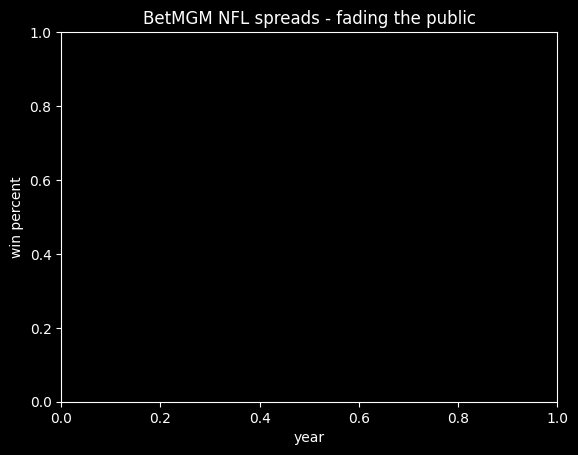

In [28]:
plt.style.use('dark_background')

plt.title("BetMGM NFL spreads - fading the public")
plt.xlabel("year")
plt.ylabel("win percent")
plt.xticks(fade_win_pct.index)
plt.yticks(np.arange(37.5, 65, 2.5))
plt.ylim([37.5,62.5])
plt.axhline(52.4, color='green', linestyle="--")
plt.axhline(100 * ci[0], color='yellow')
plt.axhline(100 * ci[1], color='yellow')
plt.plot(fade_win_pct.index, fade_win_pct.values * 100, "o-", color='dodgerblue')

can do the same thing for stake percentage

In [ ]:
(season_grouper['spread_stake_won'].value_counts() / season_grouper.count()['spread_stake_won'])[:, False]

season
2021    0.591912
2022    0.575646
2023    0.617647
2024    0.496324
2025    0.481618
dtype: float64

are there other patterns to be found? what about games where they differ?

In [ ]:
df_all[df_all.spread_stake_won != df_all.spread_popular_won].spread_stake_won.value_counts()

spread_stake_won
True     107
False    103
Name: count, dtype: int64

what if we only look at games where there's consensus between them?

In [ ]:
consensus = df_all[df_all.spread_stake_won == df_all.spread_popular_won]

consensus.spread_stake_won.value_counts()

spread_stake_won
False    648
True     501
Name: count, dtype: int64

In [ ]:
consensus_win_pct = (consensus.groupby('season')['spread_stake_won'].value_counts() / 
    consensus.groupby('season').count()['spread_stake_won'])[:, False]

In [ ]:
consensus_win_pct

season
2021    0.611814
2022    0.582222
2023    0.631799
2024    0.482759
2025    0.504630
dtype: float64

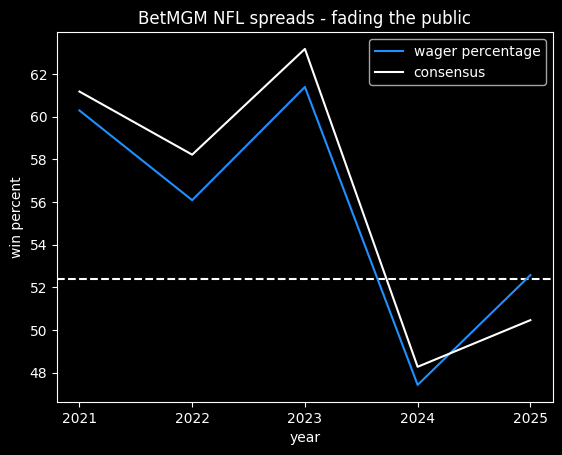

In [ ]:
plt.style.use('dark_background')

plt.title("BetMGM NFL spreads - fading the public")
plt.xlabel("year")
plt.ylabel("win percent")
plt.xticks(fade_win_pct.index)
plt.axhline(52.4, color='white', linestyle="--")
plt.plot(fade_win_pct.index, fade_win_pct.values * 100, color='dodgerblue', label="wager percentage")
plt.plot(consensus_win_pct.index, consensus_win_pct.values * 100, color='white', label="consensus")
plt.legend()


when majority num bets and stake agree, the win rate goes up to 56.5%, and is slightly more profitable (+124 vs +110.48)

In [ ]:
win_loss_report(649,500)

record:   649 - 500
full vig (-110) units: 99.0
reduced juice (-106) : 119.0
reduced juice (-105) : 124.0
betting market       : 121.03
win pct: 56.48%, expected wins: 574.5
excess: 74.5, profit %: 7.83
z test: 4.4, std: 16.95 , p-value: 0.0


the dichotomous nature of the data (home vs. away) can sometimes make analysis confusing

In [ ]:
df_all.spread_dog_won.value_counts()

spread_dog_won
True     686
False    673
Name: count, dtype: int64

NFL bettors vastly prefer taking the away team, which is odd to me, but I saw the same thing with the NBA

In [ ]:
df_all.spread_most_popular.value_counts()

spread_most_popular
AWAY    724
HOME    495
Name: count, dtype: int64

In [ ]:
723 / (723 + 496)

0.5931091058244463

this isn't that interesting because the away team is more likely to be the underdog due to home field advantage

In [ ]:
pd.crosstab(df_all.spread_dog_won, df_all.spread_home_won)

spread_home_won,False,True
spread_dog_won,,
False,275,398
True,426,260


how often do they take dogs versus favorites? it's about 2:1 favorites to underdogs

In [ ]:
df_all.spread_popular_underdog.value_counts()

spread_popular_underdog
False    877
True     482
Name: count, dtype: int64

how much do gamblers love the away favorites? what percent of all away favorites, away dogs, home favorites, home dogs, do they take?

In [ ]:
away_favorites = df_all[df_all.spread_favorite_team_name == df_all.away_team]

there were 534 games with away favorites

In [ ]:
len(away_favorites)

534

the away favorite was the more popular side in 415 of those 535 games

In [ ]:
len(away_favorites[away_favorites.spread_popular_team_name == away_favorites.away_team])

415

In [ ]:
415/535

0.7757009345794392

that means that home dogs are picked 1-.775 of the time.

what about home favorites/away dogs?

In [ ]:
home_favorites = df_all[df_all.spread_favorite_team_name == df_all.home_team]
len(home_favorites)

824

In [ ]:
len(home_favorites[home_favorites.spread_popular_team_name == home_favorites.away_team])

448

there's a preference for home favorites over away dogs, but not as much as away favorites vs. home dogs

In [ ]:
448/824

0.5436893203883495

## what spreads look like


In [ ]:
len(df_all)

1359

In [ ]:
df_all.spread_home_points.describe()

count    1358.000000
mean       -1.634389
std         6.052748
min       -20.000000
25%        -6.000000
50%        -2.500000
75%         3.000000
max        16.500000
Name: spread_home_points, dtype: float64

In [ ]:
df_all.spread_home_points.value_counts().iloc[:15]

spread_home_points
-3.0    109
 3.0     90
-3.5     89
-2.5     86
 2.5     64
 3.5     56
-6.5     51
-7.0     49
-1.5     40
 1.5     38
-7.5     37
-5.5     37
-4.5     37
 7.0     35
-4.0     32
Name: count, dtype: int64

In [ ]:
df_all.spread_home_points.median()

np.float64(-2.5)

Text(0.5, 1.0, 'NFL home spread frequencies')

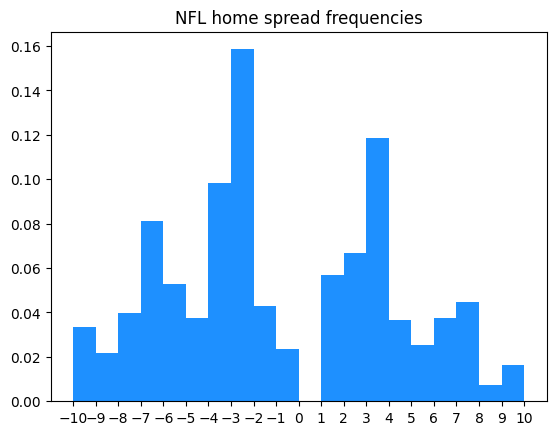

In [ ]:

plt.hist(df_all.spread_home_points, color='dodgerblue', bins=range(-10,11), density=True)
plt.xticks(range(-10,11))
plt.title("NFL home spread frequencies")


In [ ]:
df_all.spread_home_points.value_counts()

spread_home_points
-3.0     109
 3.0      90
-3.5      89
-2.5      86
 2.5      64
        ... 
-20.0      2
 11.0      2
-19.0      1
 15.0      1
-0.5       1
Name: count, Length: 64, dtype: int64

In [ ]:
def fave_won(spread):
    result = df_all[df_all.spread_home_points == spread].spread_dog_won.value_counts()
    if False in result:
        return result[False]
    else:
        return 0

spread_freq = df_all.spread_home_points.value_counts()
#(columns={'spread_home_points': 'spread'})

spread_freq.index.rename('spread', inplace=True)

spread_freq = pd.DataFrame(spread_freq)

spread_freq['cumulative %'] = np.round(100 * spread_freq.cumsum() / spread_freq.sum(), 0)

spread_table = spread_freq.copy()

# these aren't really that interesting
# spread_table['favorite_won'] = spread_table.index.map(fave_won)
# spread_table['dog_won'] = spread_table['count'] - spread_table.favorite_won

print(spread_table.iloc[:20].to_markdown())

|   spread |   count |   cumulative % |
|---------:|--------:|---------------:|
|     -3   |     109 |              8 |
|      3   |      90 |             15 |
|     -3.5 |      89 |             21 |
|     -2.5 |      86 |             28 |
|      2.5 |      64 |             32 |
|      3.5 |      56 |             36 |
|     -6.5 |      51 |             40 |
|     -7   |      49 |             44 |
|     -1.5 |      40 |             47 |
|      1.5 |      38 |             49 |
|     -7.5 |      37 |             52 |
|     -5.5 |      37 |             55 |
|     -4.5 |      37 |             58 |
|      7   |      35 |             60 |
|     -4   |      32 |             63 |
|      1   |      32 |             65 |
|     -1   |      28 |             67 |
|     -6   |      28 |             69 |
|      6.5 |      27 |             71 |
|      5.5 |      27 |             73 |


In [ ]:
spread_freq

,count,cumulative %
spread,,
-3.0,109,8.0
3.0,90,15.0
-3.5,89,21.0
-2.5,86,28.0
2.5,64,32.0
...,...,...
-20.0,2,100.0
11.0,2,100.0
-19.0,1,100.0


In [ ]:
spread_freq.cumsum() / spread_freq.sum()

,count,cumulative %
spread,,
-3.0,0.080265,0.001588
3.0,0.146539,0.004566
-3.5,0.212077,0.008735
-2.5,0.275405,0.014294
2.5,0.322533,0.020647
...,...,...
-20.0,0.996318,0.920588
11.0,0.997791,0.940441
-19.0,0.998527,0.960294


In [ ]:
spread_abs = df_all.spread_home_points.abs()

In [ ]:
len(spread_abs)

1359

In [ ]:
spread_abs.describe()

count    1358.000000
mean        5.233800
std         3.449074
min         0.500000
25%         3.000000
50%         4.000000
75%         7.000000
max        20.000000
Name: spread_home_points, dtype: float64

In [ ]:
len(spread_abs[(spread_abs >= 2.5) & (spread_abs <= 3.5)])

494

In [ ]:
495/1359

0.36423841059602646

on NBA basketball, the MGM sportsbook almost always keeps the line on the half point. that's not true for football.

In [ ]:
sum(df_all.spread_home_points.astype("str").str.endswith(".5"))

765

In [ ]:
sum(~df_all.spread_home_points.astype("str").str.endswith(".5"))

594

nonetheless, the shape is interesting. why are there so few in the -4 to -5 bucket, for instance?

Some final point differentials are going to be more likely than others (eg. losing/winning by 3 points is going to be more common than winning/losing by 5 points). so we shouldn't expect the nice smooth bell curve that we get from the NBA games.

OK, I'm gonna need to grab actual NFL game scores to prove that.

# getting actual scores and adding them

I gathered this data from pro-football-reference, eg. https://www.pro-football-reference.com/years/2025/games.htm

In [ ]:
test_2021 = pd.read_csv("nfl_scores/2021.csv")

In [ ]:
test_2021


,Week,Day,Date,Time,Winner/tie,Unnamed: 5,Loser/tie,Date.1,PtsW,PtsL,YdsW,TOW,YdsL,TOL
0,1,Thu,2021-09-09,8:20PM,Tampa Bay Buccaneers,NaN,Dallas Cowboys,boxscore,31,29,431,4,451,1
1,1,Sun,2021-09-12,1:00PM,Philadelphia Eagles,@,Atlanta Falcons,boxscore,32,6,434,0,260,0
2,1,Sun,2021-09-12,1:00PM,Pittsburgh Steelers,@,Buffalo Bills,boxscore,23,16,252,0,371,1
3,1,Sun,2021-09-12,1:00PM,Carolina Panthers,NaN,New York Jets,boxscore,19,14,381,1,252,1
4,1,Sun,2021-09-12,1:00PM,Cincinnati Bengals,NaN,Minnesota Vikings,boxscore,27,24,366,0,403,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,18,Sun,2022-01-09,1:00PM,Pittsburgh Steelers,@,Baltimore Ravens,boxscore,16,13,314,1,381,3
268,18,Sun,2022-01-09,4:25PM,Buffalo Bills,NaN,New York Jets,boxscore,27,10,424,0,53,0
269,18,Sun,2022-01-09,4:25PM,Seattle Seahawks,@,Arizona Cardinals,boxscore,38,30,431,2,305,1
270,18,Sun,2022-01-09,4:25PM,San Francisco 49ers,@,Los Angeles Rams,boxscore,27,24,449,2,265,2


In [ ]:
test_2021['Unnamed: 5']

0      NaN
1        @
2        @
3      NaN
4      NaN
      ... 
267      @
268    NaN
269      @
270      @
271    NaN
Name: Unnamed: 5, Length: 272, dtype: object

unfortunately, this is kind of an annoying way of encoding the data, since we have to deduce which is the home and away team.

In [ ]:
words = "New England Patriots".split(" ")

words[:-1]

['New', 'England']

In [ ]:
clean_year = pd.DataFrame(columns=['date', 'home_team', 'away_team', 'home_score', 'away_score'])

def match_name(long_name):
    words = long_name.split(" ")
    if words[0] == "Washington":
        return "Washington"

    if words[-1] in ["Chargers", "Rams"]:
        return f"LA {words[-1]}"
    elif words[-1] in ["Giants", "Jets"]:
        return f"NY {words[-1]}"
    else:
        return " ".join(words[:-1])

clean_rows = []

for year in range(2021, 2026):
    season_data = pd.read_csv(f"nfl_scores/{year}.csv")

    for i, row in season_data.iterrows():
        clean_row = {'date': row.Date}
        if row['Unnamed: 5'] == "@":
            # The away team won

            ### dang it, I also need to make team names match
            ### I think I can just drop the last word (except LA Rams, LA Chargers, NY Giants, NY Jets)
            clean_row['home_team'] = match_name(row['Loser/tie'])
            clean_row['away_team'] = match_name(row['Winner/tie'])
            clean_row['home_score'] = row['PtsL']
            clean_row['away_score'] = row['PtsW']

        else:
            # The home team won
            clean_row['home_team'] = match_name(row['Winner/tie'])
            clean_row['away_team'] = match_name(row['Loser/tie'])
            clean_row['home_score'] = row['PtsW']
            clean_row['away_score'] = row['PtsL']

        clean_rows.append(clean_row)


clean_rows


[{'date': '2021-09-09',
  'home_team': 'Tampa Bay',
  'away_team': 'Dallas',
  'home_score': 31,
  'away_score': 29},
 {'date': '2021-09-12',
  'home_team': 'Atlanta',
  'away_team': 'Philadelphia',
  'home_score': 6,
  'away_score': 32},
 {'date': '2021-09-12',
  'home_team': 'Buffalo',
  'away_team': 'Pittsburgh',
  'home_score': 16,
  'away_score': 23},
 {'date': '2021-09-12',
  'home_team': 'Carolina',
  'away_team': 'NY Jets',
  'home_score': 19,
  'away_score': 14},
 {'date': '2021-09-12',
  'home_team': 'Cincinnati',
  'away_team': 'Minnesota',
  'home_score': 27,
  'away_score': 24},
 {'date': '2021-09-12',
  'home_team': 'Indianapolis',
  'away_team': 'Seattle',
  'home_score': 16,
  'away_score': 28},
 {'date': '2021-09-12',
  'home_team': 'Tennessee',
  'away_team': 'Arizona',
  'home_score': 13,
  'away_score': 38},
 {'date': '2021-09-12',
  'home_team': 'Detroit',
  'away_team': 'San Francisco',
  'home_score': 33,
  'away_score': 41},
 {'date': '2021-09-12',
  'home_team'

In [ ]:
df_all.game_date.dt.strftime("%Y-%m-%d")

0    2021-09-09
0    2021-09-12
0    2021-09-12
0    2021-09-12
0    2021-09-12
        ...    
0    2026-01-04
0    2026-01-04
0    2026-01-04
0    2026-01-04
0    2026-01-04
Name: game_date, Length: 1359, dtype: object

In [ ]:

## massage date to match other dataframe
df_all['simple_date'] = df_all.game_date.dt.strftime("%Y-%m-%d")

df_scores = pd.DataFrame(clean_rows)

df_with_score = pd.concat([df_all.set_index(['simple_date', 'home_team', 'away_team']),
                        df_scores.set_index(['date', 'home_team', 'away_team'])], axis=1)

this is where I discovered that there was a postponed game in the odds data. I have removed it further up in the notebook, so the following should return 0 rows now:

In [ ]:
df_with_score[df_with_score.home_score.isna()]

,,,game_id,game_date,pregame_odds,total_over_points,total_over_stake_percentage,total_over_wager_percentage,total_over_odds,total_over_decimal_odds,total_over_won,total_under_points,...,spread_stake_popular,spread_stake_won,spread_stake_underdog,spread_favorite_team_name,spread_dog_team_name,spread_winner_team_name,spread_loser_team_name,spread_popular_team_name,home_score,away_score
,home_team,away_team,,,,,,,,,,,,,,,,,,,,,


In [ ]:

df_with_score['home_score_diff'] = df_with_score.home_score - df_with_score.away_score

df_with_score.sample(5)


,,,game_id,game_date,pregame_odds,total_over_points,total_over_stake_percentage,total_over_wager_percentage,total_over_odds,total_over_decimal_odds,total_over_won,total_under_points,...,spread_stake_won,spread_stake_underdog,spread_favorite_team_name,spread_dog_team_name,spread_winner_team_name,spread_loser_team_name,spread_popular_team_name,home_score,away_score,home_score_diff
,home_team,away_team,,,,,,,,,,,,,,,,,,,,,
2024-12-15,Cleveland,Kansas City,nfl.g.20241215005,2024-12-15 08:00:00,"-4, O/U 41",41.0,45.43,76.27,-110.0,1.910,False,41.0,...,True,False,Kansas City,Cleveland,Kansas City,Cleveland,Kansas City,7,21,-14
2023-01-08,Philadelphia,NY Giants,nfl.g.20230108021,2023-01-08 07:00:00,"-16.5, O/U 42.5",42.5,68.71,74.58,-110.0,1.910,False,42.5,...,True,True,Philadelphia,NY Giants,NY Giants,Philadelphia,NY Giants,22,16,6
2025-11-09,Houston,Jacksonville,nfl.g.20251109034,2025-11-09 08:00:00,"-1, O/U 37.5",37.5,63.14,69.12,-110.0,1.910,True,37.5,...,False,True,Houston,Jacksonville,Houston,Jacksonville,Jacksonville,36,29,7
2023-01-01,Washington,Cleveland,nfl.g.20230101028,2023-01-01 07:00:00,"-1.5, O/U 41.5",41.5,69.18,66.34,-110.0,1.910,False,41.5,...,True,True,Washington,Cleveland,Cleveland,Washington,Cleveland,10,24,-14
2024-01-06,Indianapolis,Houston,nfl.g.20240106011,2024-01-06 08:00:00,"-1, O/U 47.5",47.5,NaN,NaN,-110.0,1.910,False,47.5,...,False,False,Houston,Indianapolis,Houston,Indianapolis,Houston,19,23,-4


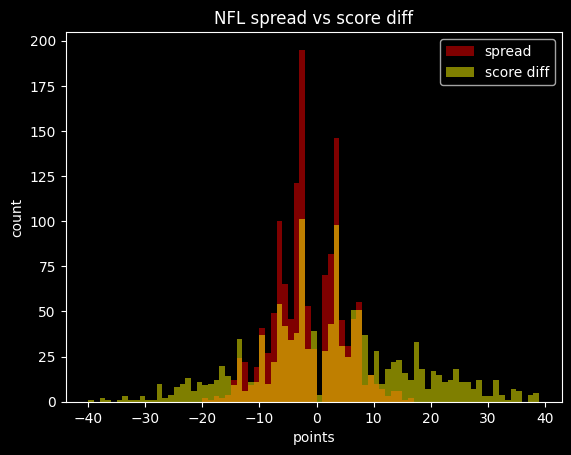

In [ ]:
bins = np.arange(-40,40,1)

plt.hist(df_with_score.spread_home_points, bins, alpha=.5, color='red', label='spread')
plt.hist(df_with_score.home_score_diff, bins, alpha=.5, color='yellow', label='score diff')
plt.title("NFL spread vs score diff")
plt.xlabel("points")
plt.ylabel("count")
_out = plt.legend(loc='upper right')


maybe it's cooler if I zoom in...

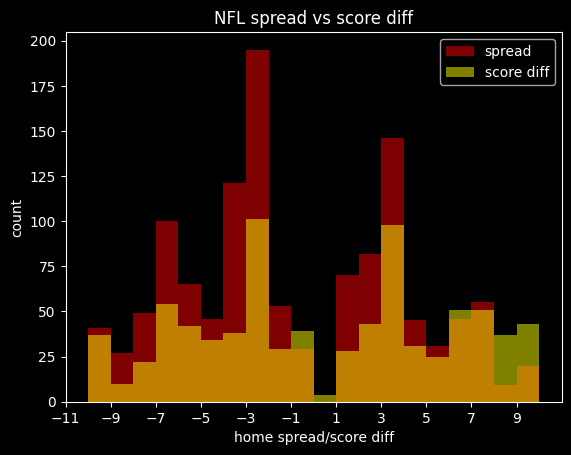

In [ ]:
bins = np.arange(-10,11,1)

plt.hist(df_with_score.spread_home_points, bins, alpha=.5, color='red', label='spread')
plt.hist(df_with_score.home_score_diff, bins, alpha=.5, color='yellow', label='score diff')
plt.title("NFL spread vs score diff")
plt.xlabel("home spread/score diff")
plt.ylabel("count")
plt.xticks(np.arange(-11,11,2))
_out = plt.legend(loc='upper right')

most common final score diffs

In [ ]:
#multiplying by -1 so it is the *fair handicap* for the home team

print((-1 * df_with_score.home_score_diff).value_counts()[:15].to_markdown())

|   home_score_diff |   count |
|------------------:|--------:|
|                 3 |     101 |
|                -3 |      98 |
|                 7 |      54 |
|                -6 |      51 |
|                -7 |      51 |
|                -2 |      43 |
|                 6 |      42 |
|                 1 |      39 |
|                 4 |      38 |
|                10 |      37 |
|                -8 |      37 |
|                14 |      35 |
|                 5 |      34 |
|               -17 |      33 |
|                -4 |      31 |


on average, the home team wins by 2 points. so the generic home field advantage is about 2 points.

In [ ]:
df_with_score.home_score_diff.describe()

count    1359.000000
mean        2.062546
std        14.187563
min       -40.000000
25%        -6.000000
50%         2.000000
75%        10.000000
max        50.000000
Name: home_score_diff, dtype: float64

the home team wins 54% of the time.

we could infer that 2 points is worth a win rate of about 54%. Someone wanting to beat the lines consistently would need to be more than 2 points better than the spread.

In [ ]:
df_with_score.money_home_won.value_counts() / len(df_with_score)

money_home_won
True     0.540103
False    0.459897
Name: count, dtype: float64

how often does a 3 point, etc. favorite win against the spread? I tried making a push chart for NBA and it was messy, so I'm going to skip this for now

### what about the error against the spread? 
(the difference between the home score diff and the spread)?

In [ ]:
df_with_score['spread_error'] = df_with_score.home_score_diff + df_with_score.spread_home_points

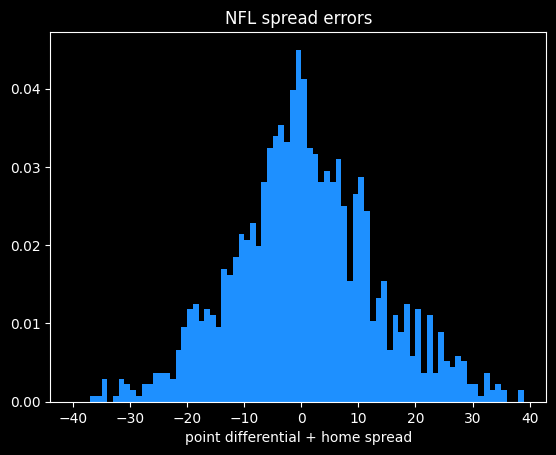

In [ ]:
plt.hist(df_with_score.spread_error, bins=np.arange(-40,40,1), color='dodgerblue',
                 density=True)
plt.xlabel("point differential + home spread")
_out = plt.title("NFL spread errors")

In [ ]:
len(df_with_score[df_with_score.spread_error > 20])

98

In [ ]:
len(df_with_score[df_with_score.spread_error < -20])

64

In [ ]:
df_with_score.spread_error.describe()

count    1358.000000
mean        0.437040
std        12.628641
min       -37.000000
25%        -7.375000
50%         0.000000
75%         8.500000
max        44.000000
Name: spread_error, dtype: float64

In [ ]:
df_with_score[df_with_score.spread_error > 10].iloc[0]

game_id                           nfl.g.20210912014
game_date                       2021-09-12 07:00:00
pregame_odds                           -9, O/U 46.5
total_over_points                              46.5
total_over_stake_percentage                   44.19
total_over_wager_percentage                   62.71
total_over_odds                              -110.0
total_over_decimal_odds                       1.910
total_over_won                                 True
total_under_points                             46.5
total_under_stake_percentage                  55.81
total_under_wager_percentage                  37.29
total_under_odds                             -110.0
total_under_decimal_odds                      1.910
total_under_won                               False
money_away_odds                               320.0
money_away_decimal_odds                       4.200
money_away_stake_percentage                    10.8
money_away_wager_percentage                     9.0
money_away_w

(array([ 10.,   0.,   1.,  20.,   0.,   0.,  20.,  18.,   3.,  19.,  58.,
          8.,   9.,  55.,  34.,  12.,  52.,  80.,  16.,  43., 100.,  40.,
         40.,  61.,  81.,  21.,  44.,  85.,  37.,  25.,  52.,  56.,  11.,
         20.,  50.,  18.,  15.,  23.,  27.,   5.,  13.,  21.,  13.,   3.,
          8.,   7.,   0.,   4.,   9.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49.]),
 <BarContainer object of 49 artists>)

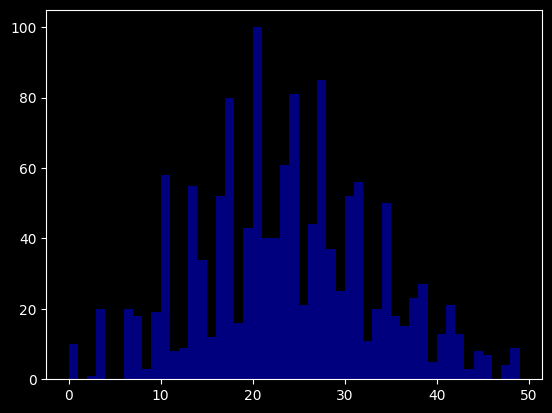

In [ ]:
score_bins = np.arange(0,50,1)
plt.hist(df_with_score.home_score, bins=score_bins, color='blue', alpha=.5)

the infamous Dolphins-Broncos game

In [ ]:
df_with_score[df_with_score.home_score == 70]

,,,game_id,game_date,pregame_odds,total_over_points,total_over_stake_percentage,total_over_wager_percentage,total_over_odds,total_over_decimal_odds,total_over_won,total_under_points,...,spread_stake_underdog,spread_favorite_team_name,spread_dog_team_name,spread_winner_team_name,spread_loser_team_name,spread_popular_team_name,home_score,away_score,home_score_diff,spread_error
,home_team,away_team,,,,,,,,,,,,,,,,,,,,,
2023-09-24,Miami,Denver,nfl.g.20230924015,2023-09-24 07:00:00,"-6, O/U 47.5",47.5,84.38,77.21,-110.0,1.910,True,47.5,...,False,Miami,Denver,Miami,Denver,Miami,70,20,50,44.0


In [ ]:
df_with_score.home_score.describe()

count    1359.000000
mean       23.543046
std        10.034448
min         0.000000
25%        17.000000
50%        23.000000
75%        30.000000
max        70.000000
Name: home_score, dtype: float64

In [ ]:
df_with_score.away_score.describe()

count    1359.000000
mean       21.480500
std         9.655679
min         0.000000
25%        15.000000
50%        21.000000
75%        28.000000
max        51.000000
Name: away_score, dtype: float64

## looking at some more basic divisions in the data

In [ ]:
df_all.columns[df_all.columns.str.contains("won")]

Index(['total_over_won', 'total_under_won', 'money_away_won', 'money_home_won',
       'spread_away_won', 'spread_home_won', 'spread_dog_won',
       'spread_popular_won', 'spread_stake_won'],
      dtype='object')

In [ ]:
_x = df_all.spread_home_won.value_counts()
_x

spread_home_won
False    701
True     658
Name: count, dtype: int64

In [ ]:
win_loss_report(658,701)

record:   658 - 701
full vig (-110) units: -113.1
reduced juice (-106) : -85.06
reduced juice (-105) : -78.05
betting market       : -74.66
win pct: 48.42%, expected wins: 679.5
excess: -21.5, profit %: -7.57
z test: -1.17, std: 18.43 , p-value: 0.8783


In [ ]:
df_all.spread_dog_won.value_counts()

spread_dog_won
True     686
False    673
Name: count, dtype: int64

In [ ]:
win_loss_report(687,673)

record:   687 - 673
full vig (-110) units: -53.3
reduced juice (-106) : -26.38
reduced juice (-105) : -19.65
betting market       : -18.05
win pct: 50.51%, expected wins: 680.0
excess: 7.0, profit %: -3.56
z test: 0.38, std: 18.44 , p-value: 0.3521


what about home dogs?

In [ ]:
df_all[df_all.spread_home_points > 0].spread_home_won.value_counts()

spread_home_won
False    274
True     260
Name: count, dtype: int64

In [ ]:
win_loss_report(260,275)

record:   260 - 275
full vig (-110) units: -42.5
reduced juice (-106) : -31.5
reduced juice (-105) : -28.75
betting market       : -27.47
win pct: 48.6%, expected wins: 267.5
excess: -7.5, profit %: -7.22
z test: -0.65, std: 11.57 , p-value: 0.7417


how about team records against the spread?

In [ ]:
# this is a bad way to do this
# keeping this as a monument to my (and man's) folly

# a1 = pd.DataFrame(df_all.groupby("away_team")["spread_away_won"].value_counts()).reset_index().rename(columns={'away_team': 'team', 'spread_away_won': 'won'})
# a2 = pd.DataFrame(df_all.groupby("home_team")["spread_home_won"].value_counts()).reset_index().rename(columns={'home_team': 'team', 'spread_home_won': 'won'})

In [ ]:
num_games = df_all.spread_winner_team_name.value_counts() + df_all.spread_loser_team_name.value_counts()

In [ ]:
record_ats = df_all.spread_winner_team_name.value_counts() / num_games

In [ ]:
record_ats.sort_values(ascending=False)

Detroit          0.635294
Pittsburgh       0.576471
Cincinnati       0.559524
Dallas           0.552941
LA Rams          0.552941
Minnesota        0.552941
LA Chargers      0.541176
Green Bay        0.529412
San Francisco    0.529412
Jacksonville     0.517647
Philadelphia     0.517647
Seattle          0.517647
Arizona          0.517647
Buffalo          0.511905
Indianapolis     0.505882
Baltimore        0.505882
Miami            0.505882
New England      0.494118
Houston          0.494118
Las Vegas        0.482353
NY Giants        0.482353
Denver           0.482353
Washington       0.470588
New Orleans      0.470588
Cleveland        0.458824
Kansas City      0.458824
Chicago          0.447059
Tampa Bay        0.447059
Carolina         0.435294
Atlanta          0.423529
Tennessee        0.423529
NY Jets          0.400000
Name: count, dtype: float64

### how do teams do when they're the popular team?

In [ ]:
popular_winners = df_all[df_all.spread_winner_team_name == df_all.spread_popular_team_name].spread_popular_team_name.value_counts()

In [ ]:
popular_losers = df_all[df_all.spread_loser_team_name == df_all.spread_popular_team_name].spread_popular_team_name.value_counts()

In [ ]:
popular_records = pd.DataFrame({'W': popular_winners, 'L': popular_losers})

In [ ]:
popular_records['win_pct'] = popular_records.W / (popular_records.W + popular_records.L)

In [ ]:
popular_records.sort_values(by='win_pct')

,W,L,win_pct
spread_popular_team_name,,,
Cleveland,12,20,0.375000
Chicago,12,20,0.375000
Las Vegas,11,18,0.379310
Tampa Bay,19,31,0.380000
Atlanta,15,24,0.384615
New Orleans,11,16,0.407407
Carolina,13,18,0.419355
Houston,17,23,0.425000
Kansas City,27,32,0.457627


winning percents seem to be in a reasonable range

<Axes: >

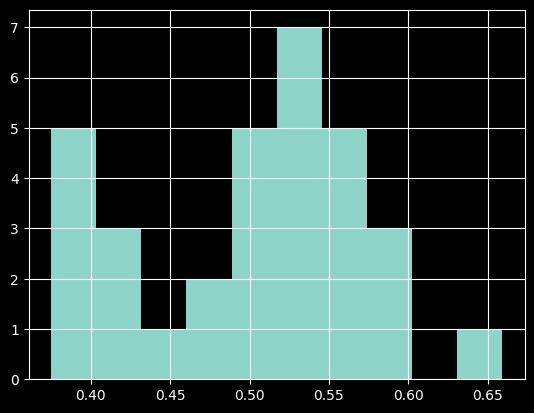

In [ ]:
popular_records.win_pct.hist()

In [ ]:
proportion_confint(count=15, nobs=30)


(0.32108058562828423, 0.6789194143717158)

# It wouldn't be a data science project without missing data

there are 126 games that are missing bet percent data

In [ ]:
len(df_all)

1359

because of that, some columns don't have `spread_most_popular` values

In [ ]:
mystery_games = df_all[df_all.spread_most_popular.isna()]

these games don't have the wager percentage

In [ ]:
mystery_games.spread_away_wager_percentage

0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
     ..
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
Name: spread_away_wager_percentage, Length: 140, dtype: float64

the missing games, by season

In [ ]:
mystery_games.season.value_counts()

season
2021    66
2023    58
2022    16
Name: count, dtype: int64

these are a pretty significant percentage of the games in 2021 and 2023. those are the two seasons with the highest winning percentages for the unpopular side of the bets, which introduces some uncertainty

In [ ]:
mystery_games.season.value_counts() / df_all.season.value_counts()

season
2021    0.242647
2022    0.059041
2023    0.213235
2024         NaN
2025         NaN
Name: count, dtype: float64

missing data leads to a confusing crosstab, because it doesn't include nulls

In [ ]:
pd.crosstab(df_all.spread_popular_won, df_all.spread_most_popular)

spread_most_popular,AWAY,HOME
spread_popular_won,,
False,369,246
True,355,249


In [ ]:
mystery_games.iloc[1]

game_id                           nfl.g.20210912019
game_date                       2021-09-12 07:00:00
away_team                                    Denver
home_team                                 NY Giants
pregame_odds                             -2, O/U 41
total_over_points                              41.0
total_over_stake_percentage                    60.4
total_over_wager_percentage                   78.34
total_over_odds                              -110.0
total_over_decimal_odds                       1.910
total_over_won                                False
total_under_points                             41.0
total_under_stake_percentage                   39.6
total_under_wager_percentage                  21.66
total_under_odds                             -110.0
total_under_decimal_odds                      1.910
total_under_won                                True
money_away_odds                              -160.0
money_away_decimal_odds                       1.630
money_away_s

a lot of these missing games are clustered on certain days. it would be hard to call it 'missing at random'

In [ ]:
mystery_games.game_date.value_counts()

game_date
2021-10-10 07:00:00    14
2023-12-31 08:00:00    14
2024-01-07 08:00:00    14
2021-10-03 07:00:00    13
2021-09-19 07:00:00    12
2021-10-17 07:00:00    12
2023-12-24 08:00:00    10
2021-09-12 07:00:00     5
2023-10-29 07:00:00     3
2023-12-25 08:00:00     3
2022-11-27 07:00:00     3
2024-01-06 08:00:00     2
2022-09-18 06:00:00     2
2022-10-23 06:00:00     2
2023-12-23 08:00:00     2
2023-12-17 08:00:00     2
2022-10-16 06:00:00     2
2022-11-20 07:00:00     2
2021-10-07 07:00:00     1
2021-09-20 07:00:00     1
2021-09-27 07:00:00     1
2021-09-13 07:00:00     1
2021-09-30 07:00:00     1
2021-10-18 07:00:00     1
2021-10-11 07:00:00     1
2022-12-18 07:00:00     1
2022-12-11 07:00:00     1
2022-12-04 07:00:00     1
2022-09-29 06:00:00     1
2021-10-31 07:00:00     1
2022-01-02 08:00:00     1
2022-01-09 08:00:00     1
2022-09-25 06:00:00     1
2023-12-21 08:00:00     1
2023-12-16 08:00:00     1
2023-11-26 08:00:00     1
2023-11-05 07:00:00     1
2023-10-08 07:00:00     1
20

## complete info on missing data by column

the line info is complete, but wager percentages are missing for a fair number of games (not sure if the same games for all categories)

In [ ]:
df_all.isna().sum()

game_id                           0
game_date                         0
away_team                         0
home_team                         0
pregame_odds                      0
total_over_points                 1
total_over_stake_percentage     142
total_over_wager_percentage     142
total_over_odds                   1
total_over_decimal_odds           1
total_over_won                    0
total_under_points                1
total_under_stake_percentage    141
total_under_wager_percentage    141
total_under_odds                  1
total_under_decimal_odds          1
total_under_won                   0
money_away_odds                   1
money_away_decimal_odds           1
money_away_stake_percentage     139
money_away_wager_percentage     133
money_away_won                    0
money_home_odds                   1
money_home_decimal_odds           1
money_home_stake_percentage     138
money_home_wager_percentage     132
money_home_won                    0
spread_away_points          

## what about point totals?

In [ ]:
df_all.total_over_won.value_counts()

total_over_won
False    701
True     658
Name: count, dtype: int64

this is quite odd... the over won 45% of the time for 3 seasons, then totally flipped

In [ ]:
(season_grouper['total_over_won'].value_counts() / df_all.season.value_counts())[:, True]

season
2021    0.455882
2022    0.453875
2023    0.455882
2024    0.529412
2025    0.525735
Name: count, dtype: float64

when the public took the over, it lost 51.8% o the time

In [ ]:
popular_over = df_all[df_all.total_over_wager_percentage > 50]

popular_over.total_over_won.value_counts() / len(popular_over)

total_over_won
False    0.522275
True     0.477725
Name: count, dtype: float64

In [ ]:
len(popular_over)

1055

In [ ]:
len(df_all)

1359

when the public took the under, it lost 53.1% of the time

In [ ]:
popular_under = df_all[df_all.total_under_wager_percentage > 50]

popular_under.total_under_won.value_counts() / len(popular_under)

total_under_won
False    0.534161
True     0.465839
Name: count, dtype: float64

this isn't counting games where it's a tie...

In [ ]:
df_all[df_all.total_over_wager_percentage == 50]

,game_id,game_date,away_team,home_team,pregame_odds,total_over_points,total_over_stake_percentage,total_over_wager_percentage,total_over_odds,total_over_decimal_odds,...,spread_popular_underdog,spread_stake_popular,spread_stake_won,spread_stake_underdog,spread_favorite_team_name,spread_dog_team_name,spread_winner_team_name,spread_loser_team_name,spread_popular_team_name,simple_date
0,nfl.g.20211107014,2021-11-07 07:00:00,Tennessee,LA Rams,"-7, O/U 53.5",53.5,49.11,50.0,-110.0,1.910,...,True,AWAY,True,True,LA Rams,Tennessee,Tennessee,LA Rams,Tennessee,2021-11-07
0,nfl.g.20251123014,2025-11-23 08:00:00,Tampa Bay,LA Rams,"-7, O/U 50",50.0,67.06,50.0,-110.0,1.910,...,True,AWAY,False,True,LA Rams,Tampa Bay,LA Rams,Tampa Bay,Tampa Bay,2025-11-23


In [ ]:
len(popular_under)

161

In [ ]:
len(df_all[df_all.total_under_wager_percentage ==50])

2

In [ ]:
consensus_over = df_all[(df_all.total_over_wager_percentage > 50) & (df_all.total_over_stake_percentage > 50)]

In [ ]:
consensus_over.total_over_won.value_counts() / len(consensus_over)

total_over_won
False    0.526814
True     0.473186
Name: count, dtype: float64

stake & wager percentages differ often with the over/unders

In [ ]:
consensus_under = df_all[(df_all.total_under_wager_percentage > 50) & (df_all.total_under_stake_percentage > 50)]
consensus_under.total_under_won.value_counts() / len(consensus_under)

total_under_won
True     0.5
False    0.5
Name: count, dtype: float64

In [ ]:
len(consensus_under)

108

what's the over/under rate by total? do higher totals go under more?

In [ ]:
df_all.total_over_points.describe()

count    1358.000000
mean       44.267305
std         4.663114
min        22.500000
25%        41.500000
50%        44.500000
75%        47.500000
max        62.500000
Name: total_over_points, dtype: float64

In [ ]:
df_all.total_over_points.mean()

np.float64(44.267304860088366)

median is more appropriate here, since there will never be a point total between 44 and 44.5

how about a 'everything's overpriced' strategy?

* take the under when point totals are >= the median

* take the over when point totals are < the median

In [ ]:
df_all[df_all.total_over_points >= df_all.total_over_points.median()].total_under_won.value_counts()

total_under_won
True     363
False    326
Name: count, dtype: int64

In [ ]:
df_all[df_all.total_over_points < df_all.total_over_points.median()].total_over_won.value_counts()

total_over_won
True     337
False    332
Name: count, dtype: int64

In [ ]:
win_loss_report(337 + 363, 326 + 332)

record:   700 - 658
full vig (-110) units: -23.8
reduced juice (-106) : 2.52
reduced juice (-105) : 9.1
betting market       : 9.81
win pct: 51.55%, expected wins: 679.0
excess: 21.0, profit %: -1.59
z test: 1.14, std: 18.43 , p-value: 0.1272


## how do point totals do by range?



In [ ]:
df_all.total_over_points.quantile(.25)

np.float64(41.5)

In [ ]:
df_all[df_all.total_over_points <= 41.5].total_over_won.value_counts()

total_over_won
True     211
False    185
Name: count, dtype: int64

In [ ]:
211 / (211 + 185)

0.5328282828282829

In [ ]:
df_all.total_over_points.quantile(.5)

np.float64(44.5)

In [ ]:
df_all[(df_all.total_over_points > 41.5) & (df_all.total_over_points <= 44.5)].total_over_won.value_counts()

total_over_won
False    200
True     161
Name: count, dtype: int64

In [ ]:
161/361

0.44598337950138506

In [ ]:
df_all.total_over_points.quantile(.75)

np.float64(47.5)

In [ ]:
df_all[(df_all.total_over_points > 44.5) & (df_all.total_over_points <= 47.5)].total_over_won.value_counts()

total_over_won
True     151
False    140
Name: count, dtype: int64

In [ ]:
151/291

0.5189003436426117

In [ ]:
df_all[(df_all.total_over_points > 47.5)].total_over_won.value_counts()

total_over_won
False    176
True     134
Name: count, dtype: int64

In [ ]:
134 / (176 + 134)

0.432258064516129

In [ ]:
from statsmodels.stats.proportion import proportion_confint

proportion_confint(count=(176+134) * .5, nobs=(176+134))


(0.44434076301412223, 0.5556592369858777)

### has fading the public on point totals changed over the years?


In [ ]:
df_all['total_popular'] = 'UNDER'
df_all.loc[df_all.total_over_wager_percentage >= 50, 'total_popular'] = 'OVER'

df_all['total_popular_won'] = False
df_all.loc[(df_all.total_popular == 'OVER') & (df_all.total_over_won), 'total_popular_won'] = True
df_all.loc[(df_all.total_popular == 'UNDER') & (df_all.total_under_won), 'total_popular_won'] = True


how often did the popular side on point total bets win by year?

In [ ]:
(df_all.groupby(["season", "total_popular_won"]).total_popular_won.count() / df_all.groupby("season").total_popular_won.count())[:,True]

season
2021    0.466912
2022    0.494465
2023    0.441176
2024    0.514706
2025    0.474265
Name: total_popular_won, dtype: float64

are point totals more likely to go over or under in blowout games?

In [ ]:
blowouts = df_with_score[np.abs(df_with_score.home_score - df_with_score.away_score) > 20]

In [ ]:
blowouts.total_over_won.value_counts()

total_over_won
True     126
False    103
Name: count, dtype: int64

In [ ]:
blowouts[~blowouts.total_over_won]

game_id           game_date  \
           home_team    away_team                                             
2021-09-12 Atlanta      Philadelphia  nfl.g.20210912001 2021-09-12 07:00:00   
           Tennessee    Arizona       nfl.g.20210912010 2021-09-12 07:00:00   
           New Orleans  Green Bay     nfl.g.20210912018 2021-09-12 07:00:00   
2021-09-19 Miami        Buffalo       nfl.g.20210919015 2021-09-19 07:00:00   
2021-09-26 Denver       NY Jets       nfl.g.20210926007 2021-09-26 07:00:00   
...                                                 ...                 ...   
2025-12-14 Chicago      Cleveland     nfl.g.20251214003 2025-12-14 08:00:00   
           Cincinnati   Baltimore     nfl.g.20251214004 2025-12-14 08:00:00   
           Philadelphia Las Vegas     nfl.g.20251214021 2025-12-14 08:00:00   
2025-12-21 New Orleans  NY Jets       nfl.g.20251221018 2025-12-21 08:00:00   
2025-12-28 Cincinnati   Arizona       nfl.g.20251228004 2025-12-28 08:00:00   

                                         pregame_odds  total_over_points  \
           home_team    away_team                                          
2021-09-12 Atlanta      Philadelphia   -3.5, O/U 48.5               48.5   
           Tennessee    Arizona            -3, O/U 54               54.0   
           New Orleans  Green Bay          -3, O/U 49               50.0   
2021-09-19 Miami        Buffalo          -3.5, O/U 47               47.0   
2021-09-26 Denver       NY Jets       -10.5, O/U 41.5               41.5   
...                                               ...                ...   
2025-12-14 Chicago      Cleveland      -7.5, O/U 38.5               38.5   
           Cincinnati   Baltimore        -3, O/U 51.5               51.5   
           Philadelphia Las Vegas       -12.5, O/U 37               37.0   
2025-12-21 New Orleans  NY Jets          -6.5, O/U 40               40.0   
2025-12-28 Cincinnati   Arizona          -7, O/U 52.5               52.5   

                                      total_over_stake_percentage  \
           home_team    away_team                                   
2021-09-12 Atlanta      Philadelphia                        94.77   
           Tennessee    Arizona                               NaN   
           New Orleans  Green Bay                           64.75   
2021-09-19 Miami        Buffalo                               NaN   
2021-09-26 Denver       NY Jets                             68.68   
...                                                           ...   
2025-12-14 Chicago      Cleveland                           75.81   
           Cincinnati   Baltimore                           74.91   
           Philadelphia Las Vegas                           65.89   
2025-12-21 New Orleans  NY Jets                             71.42   
2025-12-28 Cincinnati   Arizona                             56.26   

                                      total_over_wager_percentage  \
           home_team    away_team                                   
2021-09-12 Atlanta      Philadelphia                        91.39   
           Tennessee    Arizona                               NaN   
           New Orleans  Green Bay                           56.20   
2021-09-19 Miami        Buffalo                               NaN   
2021-09-26 Denver       NY Jets                             67.09   
...                                                           ...   
2025-12-14 Chicago      Cleveland                           74.98   
           Cincinnati   Baltimore                           64.43   
           Philadelphia Las Vegas                           78.89   
2025-12-21 New Orleans  NY Jets                             69.64   
2025-12-28 Cincinnati   Arizona                             40.80   

                                      total_over_odds total_over_decimal_odds  \
           home_team    away_team                                               
2021-09-12 Atlanta      Philadelphia           -110.0                   1

In [ ]:
win_loss_report(126,103)

record:   126 - 103
full vig (-110) units: 12.7
reduced juice (-106) : 16.82
reduced juice (-105) : 17.85
betting market       : 17.47
win pct: 55.02%, expected wins: 114.5
excess: 11.5, profit %: 5.04
z test: 1.52, std: 7.57 , p-value: 0.0643


this is misleading because there's a hidden conditional probability problem:

To win by > 20, at least one team has to score 20.

In [ ]:
high_scores = df_with_score[(df_with_score.home_score > 20) | (df_with_score.away_score > 20)]
high_scores.total_over_won.value_counts()

total_over_won
True     657
False    424
Name: count, dtype: int64

In [ ]:
win_loss_report(657,424)

record:   657 - 424
full vig (-110) units: 190.6
reduced juice (-106) : 207.56
reduced juice (-105) : 211.8
betting market       : 206.08
win pct: 60.78%, expected wins: 540.5
excess: 116.5, profit %: 16.03
z test: 7.09, std: 16.44 , p-value: 0.0


blowouts are a subset of the above set. if you condition on at least one team scoring 20, then a blowout is *less* likely to go over than a non-blowout

In [ ]:
high_scores[np.abs(high_scores.home_score - high_scores.away_score) > 20].total_over_won.value_counts()

total_over_won
True     126
False    103
Name: count, dtype: int64

## Point total errors

How off are the point totals? does that tell us anything interesting?


In [ ]:
df_with_score['total_points_scored'] = df_with_score.home_score + df_with_score.away_score

In [ ]:
df_with_score.total_points_scored.describe()

count    1359.000000
mean       45.023547
std        13.658610
min         3.000000
25%        36.000000
50%        44.000000
75%        54.000000
max        93.000000
Name: total_points_scored, dtype: float64

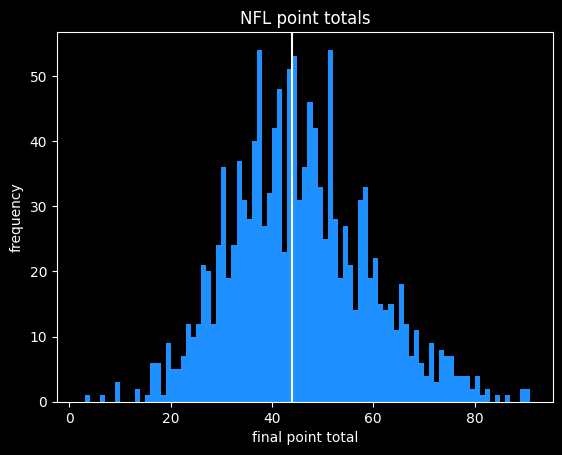

In [ ]:
plt.hist(df_with_score.total_points_scored, bins=np.arange(2,92,1), color='dodgerblue')
plt.xlabel("final point total")
plt.ylabel("frequency")
plt.axvline(44)
_out = plt.title("NFL point totals")

In [ ]:
len(df_with_score[df_with_score.total_points_scored > df_with_score.total_over_points])

657

csd TODO: how off are point totals?

In [ ]:
df_with_score['total_error'] = df_with_score.total_points_scored - df_with_score.total_over_points

In [ ]:
df_with_score.total_error.describe()

count    1358.000000
mean        0.767305
std        13.402751
min       -37.500000
25%        -8.500000
50%        -0.500000
75%         9.000000
max        57.500000
Name: total_error, dtype: float64

In [ ]:
df_with_score.total_error.abs().describe()

count    1358.000000
mean       10.561119
std         8.282722
min         0.000000
25%         4.000000
50%         8.500000
75%        14.500000
max        57.500000
Name: total_error, dtype: float64

In [ ]:
df_with_score[df_with_score.total_error.isna()]

,,,game_id,game_date,pregame_odds,total_over_points,total_over_stake_percentage,total_over_wager_percentage,total_over_odds,total_over_decimal_odds,total_over_won,total_under_points,...,spread_dog_team_name,spread_winner_team_name,spread_loser_team_name,spread_popular_team_name,home_score,away_score,home_score_diff,spread_error,total_points_scored,total_error
,home_team,away_team,,,,,,,,,,,,,,,,,,,,,
2022-09-18,New Orleans,Tampa Bay,nfl.g.20220918018,2022-09-18 06:00:00,"-2.5, O/U 43.5",NaN,NaN,NaN,NaN,NaN,True,NaN,...,None,New Orleans,Tampa Bay,Tampa Bay,10,20,-10,NaN,30,NaN


there is one game that doesn't have the spread_error and total_error because it is missing data (not sure why it wasn't already dropped.)

In [ ]:
df_with_score = df_with_score.dropna(subset=['total_error'])

a positive value is the number of points greater than the over
a negative value is number of points less than the over

we should probably expect bigger outliers in the positive direction, because you can't score less than 0 points, but the max number of points is theoretically unlimited.

the point total is positively skewed to a significant degree

In [ ]:
from scipy.stats import skewtest
skewtest(df_with_score.total_error)

SkewtestResult(statistic=np.float64(6.044314667492433), pvalue=np.float64(1.5004641847288588e-09))

In [ ]:
df_with_score.total_over_won.value_counts()

total_over_won
False    701
True     657
Name: count, dtype: int64

In [ ]:
win_loss_report(658,701)

record:   658 - 701
full vig (-110) units: -113.1
reduced juice (-106) : -85.06
reduced juice (-105) : -78.05
betting market       : -74.66
win pct: 48.42%, expected wins: 679.5
excess: -21.5, profit %: -7.57
z test: -1.17, std: 18.43 , p-value: 0.8783


the biggest error on the total ever (final score was 63-21)

In [ ]:
df_with_score[df_with_score.total_error == 57.5]

,,,game_id,game_date,pregame_odds,total_over_points,total_over_stake_percentage,total_over_wager_percentage,total_over_odds,total_over_decimal_odds,total_over_won,total_under_points,...,spread_dog_team_name,spread_winner_team_name,spread_loser_team_name,spread_popular_team_name,home_score,away_score,home_score_diff,spread_error,total_points_scored,total_error
,home_team,away_team,,,,,,,,,,,,,,,,,,,,,
2023-12-14,Las Vegas,LA Chargers,nfl.g.20231214013,2023-12-14 08:00:00,"-3, O/U 36",26.5,87.5,90.63,-500.0,1.200,True,26.5,...,LA Chargers,Las Vegas,LA Chargers,Las Vegas,63,21,42,39.0,84,57.5


how often are the errors on the half point? (or totals, rather)

In [ ]:
sum(df_with_score.total_over_points.astype(str).str.endswith(".5")) / len(df_with_score)

0.593519882179676

sanity check: there should be as many errors on the half point as lines.

In [ ]:
sum(df_with_score.total_error.astype(str).str.endswith(".5"))

806

In [ ]:
806/1358

0.593519882179676

did betmgm start having more point totals on the .5?

In [ ]:
df_with_score['half_point'] = df_with_score.total_error.astype(str).str.endswith(".5")

no, they've pretty consistently put around 60% of games on the half point. (2024 was a bit of an outlier)

In [ ]:
df_with_score.groupby(["season", "half_point"]).half_point.count() / df_with_score.groupby(["season"]).half_point.count()

season  half_point
2021    False         0.422794
        True          0.577206
2022    False         0.370370
        True          0.629630
2023    False         0.397059
        True          0.602941
2024    False         0.477941
        True          0.522059
2025    False         0.363971
        True          0.636029
Name: half_point, dtype: float64

point totals almost never push, which is a bit odd

In [ ]:
total_pushes = df_with_score[df_with_score.total_error == 0]

In [ ]:
len(total_pushes)

12

In [ ]:
len(df_with_score)

1358

what do absolute values of point total errors look like?

<Axes: >

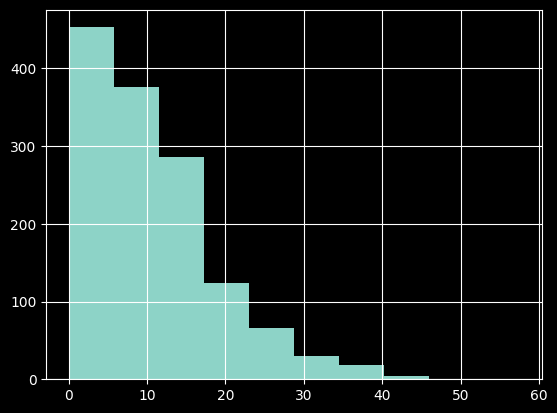

In [ ]:
df_with_score.total_error.abs().hist()

TODO? calculate implied final game score from the combo of point total and spread

Not sure what I'd do with it right now

### what do over/under errors look like?

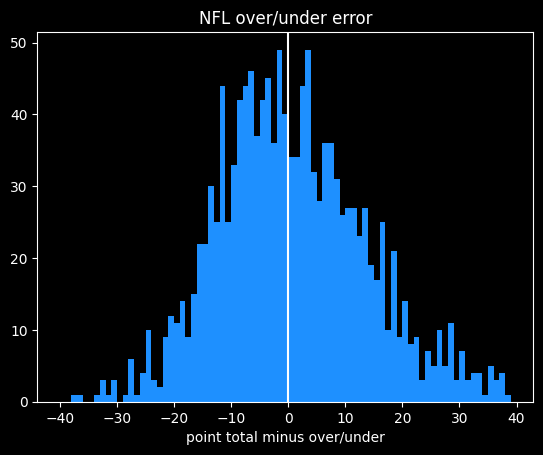

In [ ]:
b= np.arange(-40,40,1)

plt.title("NFL over/under error")
plt.xlabel("point total minus over/under")
plt.axvline(0)
_out = plt.hist(df_with_score.total_error, b, color='dodgerblue')

In [ ]:
print(df_with_score.total_error.value_counts().iloc[:15].to_markdown())

|   total_error |   count |
|--------------:|--------:|
|          -6.5 |      30 |
|         -11.5 |      29 |
|          -3.5 |      29 |
|           3.5 |      28 |
|          -7.5 |      27 |
|           6.5 |      25 |
|          -2   |      25 |
|          -1.5 |      24 |
|          -4.5 |      23 |
|           2.5 |      23 |
|           1.5 |      23 |
|           7.5 |      22 |
|          -0.5 |      22 |
|           0.5 |      22 |
|          -8.5 |      22 |


is there a correlation between high point totals for one team and the other?

I guess it should be negative, if one team scores a bunch of points there's less time for the other team to score. but it seems like teams might have to play faster/be more aggressive when the other team is scoring lotsa points

In [ ]:
df_with_score.away_score.corr(df_with_score.home_score)

np.float64(-0.03818400096246662)

I wouldn't say there's a strong pattern in the correlation between home & away scores

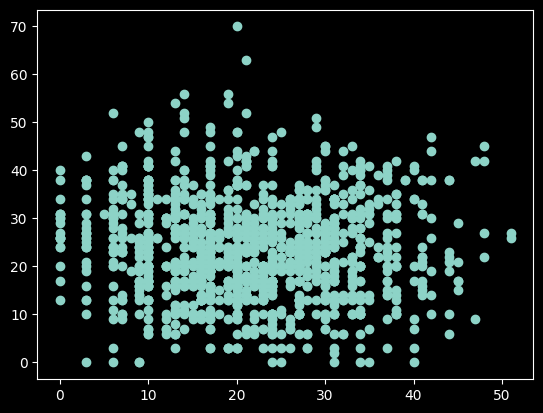

In [ ]:
plt.scatter(df_with_score.away_score, df_with_score.home_score)

this is about what we'd expect

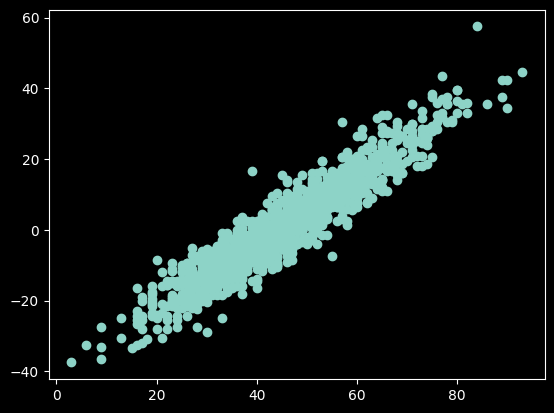

In [ ]:
plt.scatter(df_with_score.total_points_scored, df_with_score.total_error)

In [ ]:
df_with_score.home_score.describe()

count    1358.000000
mean       23.553019
std        10.031405
min         0.000000
25%        17.000000
50%        23.000000
75%        30.000000
max        70.000000
Name: home_score, dtype: float64

how frequent are "shootouts" (where both teams score more than the median number of points?)

since home_score and away_score aren't strongly correlated with each other, by definition it should be close to 25%.

In [ ]:
shootouts = df_with_score[(df_with_score.home_score > df_with_score.home_score.median()) & 
                          (df_with_score.away_score > df_with_score.away_score.median())]

In [ ]:
len(shootouts)

311

In [ ]:
len(shootouts) / len(df_with_score)

0.22901325478645065

what about correlation between the error on the spread and error on the point total?

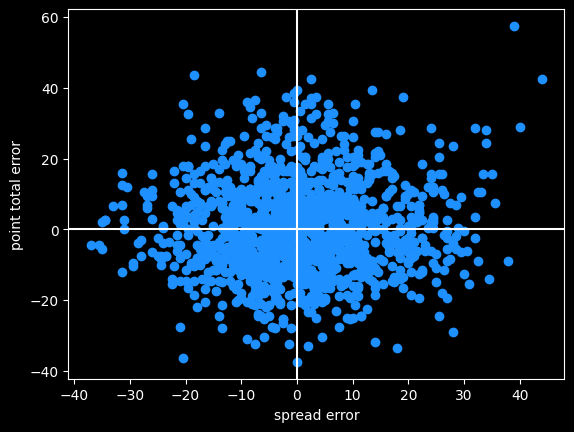

In [ ]:
plt.scatter(df_with_score.spread_error, df_with_score.total_error, color='dodgerblue')
plt.xlabel("spread error")
plt.ylabel("point total error")
plt.axhline(0)
_out = plt.axvline(0)

In [ ]:
df_with_score.spread_error.corr(df_with_score.total_error)

np.float64(0.03848379128901756)

## what about money lines

add_money_columns will drop the games without the `money_home_won` field, so I create a new dataframe

In [ ]:
import money_data

df_money = money_data.add_money_columns(df_all.copy())


the public greatly prefers the favorite on the money line.

In [ ]:
df_money.money_fave_dog.value_counts()

money_fave_dog
FAVE    1180
DOG       47
Name: count, dtype: int64

median money line bet is -200 (taking the mean of money line odds doesn't make sense)

In [ ]:
df_money.money_popular_odds.astype('float').median()

np.float64(-200.0)

## What if a bettor always took the popular side of the money line?

I've added `*_payout` fields for the exact payout on a $100 bet

In [ ]:
df_money.iloc[0]

game_id                   nfl.g.20210909027
game_date               2021-09-09 07:00:00
away_team                            Dallas
home_team                         Tampa Bay
pregame_odds                   -9, O/U 52.5
                               ...         
money_popular_odds                   -450.0
money_overround                    1.040404
money_away_payout                     350.0
money_home_payout                 22.222222
money_popular_payout              22.222222
Name: 0, Length: 65, dtype: object

In [ ]:
df_money.iloc[1:5,:]

,game_id,game_date,away_team,home_team,pregame_odds,total_over_points,total_over_stake_percentage,total_over_wager_percentage,total_over_odds,total_over_decimal_odds,...,total_popular,total_popular_won,money_popular,money_popular_won,money_fave_dog,money_popular_odds,money_overround,money_away_payout,money_home_payout,money_popular_payout
0,nfl.g.20210912001,2021-09-12 07:00:00,Philadelphia,Atlanta,"-3.5, O/U 48.5",48.5,94.77,91.39,-110.0,1.910,...,OVER,False,HOME,False,FAVE,-175.0,1.044527,145.000000,57.142857,57.142857
0,nfl.g.20210912002,2021-09-12 07:00:00,Pittsburgh,Buffalo,"-6.5, O/U 48",48.0,87.16,90.98,-110.0,1.910,...,OVER,False,HOME,False,FAVE,-275.0,1.041026,225.000000,36.363636,36.363636
0,nfl.g.20210912004,2021-09-12 07:00:00,Minnesota,Cincinnati,"-3, O/U 47",47.0,NaN,NaN,-110.0,1.910,...,UNDER,False,AWAY,False,FAVE,-150.0,1.044444,66.666667,125.000000,66.666667
0,nfl.g.20210912008,2021-09-12 07:00:00,San Francisco,Detroit,"-7.5, O/U 45.5",45.5,83.16,92.43,-110.0,1.910,...,OVER,True,AWAY,True,FAVE,-350.0,1.040936,28.571429,280.000000,28.571429


`money_converted` is how much money we'd win risking $100 on each bet. quick sanity check --

In [ ]:
df_money[df_money.money_home_wager_percentage.isna()]

,game_id,game_date,away_team,home_team,pregame_odds,total_over_points,total_over_stake_percentage,total_over_wager_percentage,total_over_odds,total_over_decimal_odds,...,total_popular,total_popular_won,money_popular,money_popular_won,money_fave_dog,money_popular_odds,money_overround,money_away_payout,money_home_payout,money_popular_payout


In [ ]:
df_money.loc[df_money.money_popular_won, ['money_popular_payout', 'money_popular_odds', 'money_popular_won']]

,money_popular_payout,money_popular_odds,money_popular_won
0,22.222222,-450.0,True
0,28.571429,-350.0,True
0,66.666667,-150.0,True
0,40.000000,-250.0,True
0,25.000000,-400.0,True
...,...,...,...
0,9.090909,-1100.0,True
0,12.500000,-800.0,True
0,9.090909,-1100.0,True
0,12.500000,-800.0,True


the popular side doesn't do that bad, actually. they're taking median -200 odds and winning 66.4% of the time. that's a very small margin for the sportsbook -- the public is making close to the implied odds of a -200 bet.

In [ ]:
df_money.money_popular_won.value_counts() / len(df_money)

money_popular_won
True     0.664222
False    0.335778
Name: count, dtype: float64

because of the wackiness of money lines, need to look at the median

In [ ]:
df_money.money_popular_odds.astype(int).median()

np.float64(-200.0)

calculate profit/loss taking every money line bet

In [ ]:
moneyline_profit = df_money[df_money.money_popular_won].money_popular_payout.sum() - (100 * (sum(~df_money.money_popular_won)))

In [ ]:
moneyline_profit

np.float64(-3817.892512623468)

a little better than the usual -4.5% on spread bets

In [ ]:
moneyline_profit / (100 * len(df_money))

np.float64(-0.031115668399539265)

In [ ]:
df_money[df_money.money_popular_won].money_popular_payout.sum()

np.float64(37382.10748737653)

In [ ]:
(100 * (sum(~df_money.money_popular_won)))

41200

### how often the public took the favorite on the money line

In [ ]:
sum(df_money.money_popular_odds < 0)

1180

In [ ]:
len(df_money)

1227

In [ ]:
1181/1228

0.9617263843648208

## the overround

the problem is, we don't know what the vig *really* is. can I get that by looking at all money lines? yes, I can. just calculate overround for every single bet (now added to analysis code)

In [ ]:
df_money.money_overround.describe()

count    1227.000000
mean        1.044356
std         0.003797
min         1.030303
25%         1.041408
50%         1.044289
75%         1.047079
max         1.059113
Name: money_overround, dtype: float64

(array([  2.,  19.,  42., 260., 414., 239., 200.,  25.,  23.,   3.]),
 array([1.03030303, 1.03318406, 1.03606508, 1.03894611, 1.04182714,
        1.04470817, 1.04758919, 1.05047022, 1.05335125, 1.05623227,
        1.0591133 ]),
 <BarContainer object of 10 artists>)

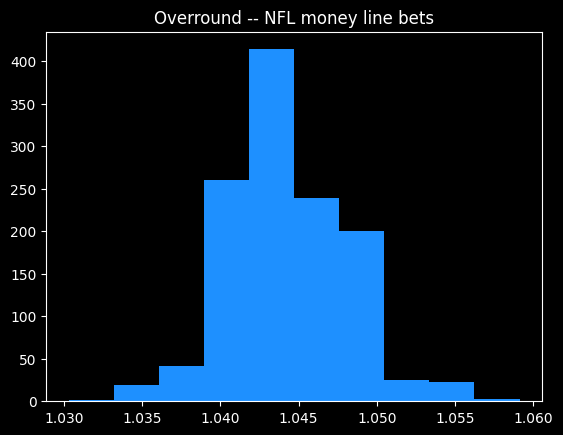

In [ ]:
#df_money.money_overround.hist()

plt.title("Overround -- NFL money line bets")
plt.hist(df_money.money_overround, color='dodgerblue')

On paper, it's awful close to 4.5%, just like -110 spread bets.

the public is doing better than chance, a bit.

I could prove that with a random simulation.

In [ ]:

some_outcomes = []
NUM_OUTCOMES = 100


for run in range(NUM_OUTCOMES):
    random_p_l = []
    # simulate taking random money line picks, and betting $100 on them
    for idx, row in df_money.iterrows():
        # for each row, flip a virtual coin to decide side to take, then record whether it made/lost money
        home_vs_away = rng.choice(["home", "away"])
        won = row[f"money_{home_vs_away}_won"]
        if won:
            random_p_l.append(row[f"money_{home_vs_away}_payout"])
        else:
            random_p_l.append(-100)
    some_outcomes.append(random_p_l)


In [ ]:
outcomes = pd.Series(map(sum, some_outcomes))

<Axes: >

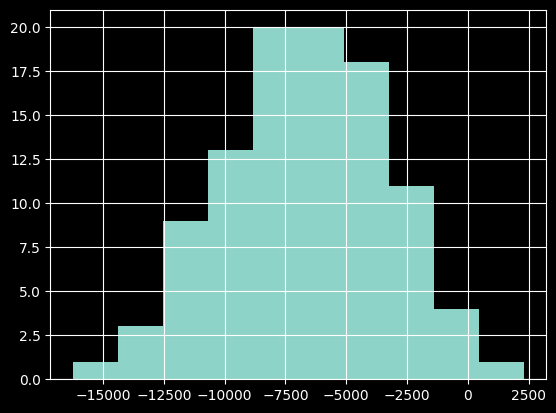

In [ ]:
outcomes.hist()

so yeah, the public did better than simulation (around one std better than the mean)

In [ ]:
outcomes.describe()

count      100.000000
mean     -6637.597464
std       3346.139606
min     -16233.284032
25%      -8885.830266
50%      -6450.319447
75%      -4330.936976
max       2310.375175
dtype: float64

In [ ]:
#!pip install scikits.bootstrap

In [ ]:
## adding bootstrapping library to get confidence intervals for the EV
import scikits.bootstrap as boot
import numpy as np

## Investigating EV by type of money line bet

copy/pasted from explore.ipynb notebook & modified to add bootstrapping, not really interesting enough to make its own module


In [ ]:

config = {
    'all favorites': [-9999, -1],
    'mild favorites': [-200, -1],
    'heavy favorites': [-400, -200],
    'huge favorites': [-9999, -400],
    
    'all dogs': [1, 9999],
    'mild dogs': [1, 200],
    'heavy dogs': [200, 400],
    'huge dogs': [400, 9999],

    'everythang': [-9999, 9999]
}

def run_moneyline_sim(name, start, end, dataframe=df_money, quiet=False):
    net_profit = 0
    games_bet = 0
    payouts = []
    for idx, game in dataframe.iterrows():
        if game.money_home_odds >= start and (game.money_home_odds < end):
            profit = game.money_home_payout

            if game.money_home_won:
                net_profit = net_profit + profit
                payouts.append(profit)
            else:
                net_profit = net_profit - 100
                payouts.append(-100)
            games_bet +=1

        ## note: this shouldn't be an 'elif' because both sides could be 
        if game.money_away_odds >= start and (game.money_away_odds < end):
            profit = game.money_away_payout

            if game.money_away_won:
                net_profit = net_profit + profit
                payouts.append(profit)
            else:
                net_profit = net_profit - 100
                payouts.append(-100)
            games_bet +=1

    boot_ci = boot.ci(payouts, np.sum, alpha=.1)
    if not quiet:
        #print(f"{name} ({start}, {end}) profit is {net_profit}, games: {games_bet}, per game {net_profit/games_bet}")
        print(f"| {name} | {start} | {end} | {games_bet}  | {boot_ci[0]/games_bet:.1f}% | {net_profit/games_bet:.1f}% | {boot_ci[1]/games_bet:.1f}%")
    else:
        return payouts

for k,v in config.items():
    run_moneyline_sim(k, *v)

| all favorites | -9999 | -1 | 1270  | -7.0% | -3.8% | -0.6%
| mild favorites | -200 | -1 | 661  | -8.0% | -2.7% | 2.5%
| heavy favorites | -400 | -200 | 406  | -12.7% | -7.5% | -2.5%
| huge favorites | -9999 | -400 | 203  | -5.4% | -0.2% | 4.1%
| all dogs | 1 | 9999 | 1184  | -14.0% | -7.2% | -0.2%
| mild dogs | 1 | 200 | 662  | -12.6% | -5.3% | 2.2%
| heavy dogs | 200 | 400 | 399  | -16.2% | -3.4% | 10.7%
| huge dogs | 400 | 9999 | 123  | -55.7% | -29.7% | 5.3%
| everythang | -9999 | 9999 | 2454  | -9.1% | -5.5% | -1.6%


In [ ]:
(1056 + 161)

1217

In [ ]:
p = run_moneyline_sim('test', -9999, -400, quiet=True)
boot.ci(p, np.sum, alpha=.1) / len(p)

array([-5.14900138,  4.09787543])

### diagnosing a weird thought I had

My naive thought was... shouldn't all dogs and all favorites together average out to be the same as the overround (which is around 4.5% on all bets?)

In [ ]:
df_money[df_money.money_away_won].money_away_payout.sum()

np.float64(59157.29754299155)

In [ ]:
len(df_money[~df_money.money_away_won]) * 100

67100

In [ ]:
(59157 - 67200) / len(df_money)

-6.555012224938875

In [ ]:
df_money[df_money.money_home_won].money_home_payout.sum()

np.float64(50551.65985930701)

In [ ]:
len(df_money[~df_money.money_home_won]) * 100

56000

so here's the -5.65% as seen in the 'everythang'

In [ ]:
(59158 - 67200 + 50362 -56200) / (100 * 2 * len(df_money))

-0.05656071719641402

In [ ]:
## troubleshooting above question
df_money['money_away_implied'] = df_money.money_away_odds.map(convert_line) 
df_money['money_home_implied'] = df_money.money_home_odds.map(convert_line) 
test_evs = 100 - ((df_money.money_away_implied * df_money.money_away_payout) + (df_money.money_home_implied * df_money.money_home_payout))

if I multiply the implied odds by the payout, then subtract 100, that should be the overround.
Looks like it is (modulo a little floating point imprecision)

In [ ]:
test_evs.describe()

count    1227.000000
mean        4.435559
std         0.379703
min         3.030303
25%         4.140787
50%         4.428904
75%         4.707884
max         5.911330
dtype: float64

In [ ]:
huge_home_dogs = df_money[df_money.money_home_odds >= 400]
len(huge_home_dogs[huge_home_dogs.money_home_won])

8

In [ ]:
len(huge_home_dogs)

31

In [ ]:
sum(huge_home_dogs[huge_home_dogs.money_home_won].money_home_payout)

4400.0

In [ ]:
len(huge_home_dogs[~huge_home_dogs.money_home_won])

23

In [ ]:
huge_home_dogs.money_home_odds.median()

np.float64(500.0)

In [ ]:
(100/600) * 31

5.166666666666666

## huge away dogs

In [ ]:
huge_away_dogs = df_money[df_money.money_away_odds >= 400]
len(huge_away_dogs[huge_away_dogs.money_away_won])

6

In [ ]:
len(huge_away_dogs)

92

In [ ]:
huge_away_dogs.money_away_odds.mean()

np.float64(600.5434782608696)

expected number of wins, based on implied odds

In [ ]:
(100/700) * 92

13.142857142857142

In [ ]:
sum(huge_away_dogs[huge_away_dogs.money_away_won].money_away_payout)

2850.0

In [ ]:
len(huge_away_dogs[~huge_away_dogs.money_away_won]) * 100

8600

In [ ]:
100 * len(huge_away_dogs)

9200

In [ ]:
(2850 - 8600) / 9200

-0.625

In [ ]:
### rando debugging/sanity checking
df_money[df_money.money_home_odds == -400].sample(5)

,game_id,game_date,away_team,home_team,pregame_odds,total_over_points,total_over_stake_percentage,total_over_wager_percentage,total_over_odds,total_over_decimal_odds,...,money_popular,money_popular_won,money_fave_dog,money_popular_odds,money_overround,money_away_payout,money_home_payout,money_popular_payout,money_away_implied,money_home_implied
0,nfl.g.20231123008,2023-11-23 08:00:00,Green Bay,Detroit,"-8.5, O/U 47",36.5,69.90,59.69,-450.0,1.220,...,HOME,False,FAVE,-400.0,1.043902,310.0,25.0,25.0,0.243902,0.8
0,nfl.g.20251214003,2025-12-14 08:00:00,Cleveland,Chicago,"-7.5, O/U 38.5",38.5,75.81,74.98,-105.0,1.950,...,HOME,True,FAVE,-400.0,1.043902,310.0,25.0,25.0,0.243902,0.8
0,nfl.g.20241124034,2024-11-24 08:00:00,Tennessee,Houston,"-8, O/U 40.5",40.5,63.52,77.42,-110.0,1.910,...,HOME,False,FAVE,-400.0,1.043902,310.0,25.0,25.0,0.243902,0.8
0,nfl.g.20221009009,2022-10-09 06:00:00,NY Giants,Green Bay,"-10, O/U 41.5",41.5,73.97,67.44,-110.0,1.910,...,HOME,False,FAVE,-400.0,1.043902,310.0,25.0,25.0,0.243902,0.8
0,nfl.g.20220102011,2022-01-02 08:00:00,Las Vegas,Indianapolis,"-8.5, O/U 46.5",46.5,78.67,73.96,-110.0,1.910,...,HOME,False,FAVE,-400.0,1.035294,325.0,25.0,25.0,0.235294,0.8


# weird pandas issue
this is for the blog. turns out I've used python for 25 years without ever learning what ~x where x is an integer does

In [ ]:
df_money.money_home_won

0     True
0     True
0    False
0     True
0    False
     ...  
0     True
0    False
0     True
0     True
0     True
Name: money_home_won, Length: 272, dtype: object

In [ ]:
negate = ~df_money.money_home_won
negate

0    False
0     True
0     True
0    False
0     True
     ...  
0    False
0     True
0    False
0    False
0    False
Name: money_home_won, Length: 1227, dtype: bool

In [ ]:
negate.value_counts()

money_home_won
False    667
True     560
Name: count, dtype: int64

In [ ]:
sum(negate)

560

it works as expected when casting it as boolean

In [ ]:
negate2 = ~(df_money.money_home_won.astype(bool))

In [ ]:
negate2

0    False
0     True
0     True
0    False
0     True
     ...  
0    False
0     True
0    False
0    False
0    False
Name: money_home_won, Length: 1227, dtype: bool

### the concise version of the problem

In [ ]:
x = pd.Series([True, False, True])

In [ ]:
x.dtype

dtype('bool')

when I loaded my data, it ended up being an `object` type, (there may have been nulls that I later dropped)

In [ ]:
x.astype(object)

0     True
1    False
2     True
dtype: object

this mostly behaves as expected...

In [ ]:
sum(x.astype(object))

2

In [ ]:
x_o = x.astype(object)

In [ ]:
x_o[x_o == True]

0    True
2    True
dtype: object

In [ ]:
sum(x_o)

2

so far so good, but something horrible happens if you negate the Series with `dtype == object`:

In [ ]:
~x_o

0    -2
1    -1
2    -2
dtype: object

In [ ]:
sum(~x_o)

-5

In [ ]:
~x_o == True

0    False
1    False
2    False
dtype: bool

random nonsense

In [ ]:
df_all[df_all.season == 2025].spread_winner_team_name.value_counts()

spread_winner_team_name
Jacksonville     12
LA Rams          12
New England      12
Seattle          12
Carolina         10
Philadelphia     10
San Francisco    10
Chicago          10
Pittsburgh       10
NY Giants         9
Atlanta           9
LA Chargers       9
Indianapolis      9
Houston           9
New Orleans       9
Minnesota         8
Buffalo           8
Cleveland         8
Cincinnati        8
Detroit           8
Miami             8
Dallas            7
Green Bay         7
Las Vegas         7
Tennessee         7
Denver            7
NY Jets           7
Washington        7
Baltimore         6
Arizona           6
Kansas City       6
Tampa Bay         5
Name: count, dtype: int64

In [ ]:
df_all[df_all.season == 2024].spread_winner_team_name.value_counts()

spread_winner_team_name
Detroit          12
Denver           12
LA Chargers      12
Minnesota        12
Arizona          11
Philadelphia     11
Pittsburgh       11
Washington       11
Tampa Bay        10
Cincinnati       10
Buffalo          10
Jacksonville     10
Baltimore        10
Indianapolis      9
Chicago           9
LA Rams           9
Green Bay         9
Kansas City       8
Las Vegas         8
Carolina          8
Houston           7
New Orleans       7
New England       7
Dallas            7
Seattle           7
Miami             7
Atlanta           6
NY Jets           6
San Francisco     5
NY Giants         5
Cleveland         4
Tennessee         2
Name: count, dtype: int64

## more overflow stuff... changes to betmgm lines/info around 2024. 

did lines get better? did win rates fading the public on spreads mirror those on point totals?

In [ ]:
spread_fade_win_pct = fade_win_pct
spread_fade_win_pct

season
2021    0.602941
2022    0.560886
2023    0.613971
2024    0.474265
2025    0.525735
dtype: float64

I calculated this above... total_popular_won is the field needed.

In [ ]:
total_fade_win_pct = 1 - (df_all.groupby(["season", "total_popular_won"]).total_popular_won.count() / df_all.groupby("season").total_popular_won.count())[:,True]

In [ ]:
total_fade_win_pct

season
2021    0.533088
2022    0.505535
2023    0.558824
2024    0.485294
2025    0.525735
Name: total_popular_won, dtype: float64

not gonna use this one -- confusing

In [ ]:
total_over_win_pct = (season_grouper['total_over_won'].value_counts() / df_all.season.value_counts())[:, True]

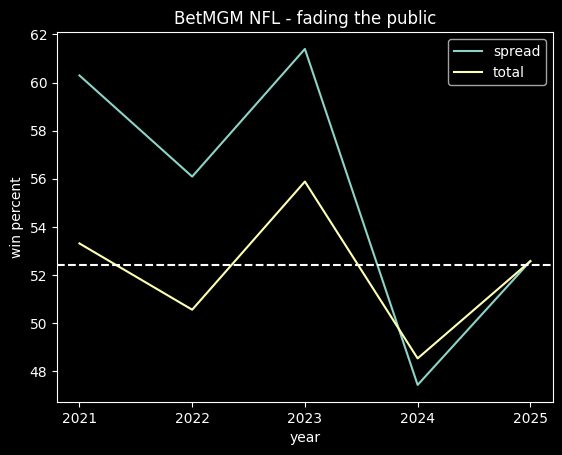

In [ ]:

plt.title("BetMGM NFL - fading the public")
plt.xlabel("year")
plt.ylabel("win percent")
plt.xticks(spread_fade_win_pct.index)
plt.plot(spread_fade_win_pct.index, spread_fade_win_pct.values * 100, label="spread")
plt.plot(total_fade_win_pct.index, total_fade_win_pct.values * 100, label="total")
plt.axhline(52.4, color="white", linestyle="--")
plt.legend()
